The directories are listed as follows:

1/ wind + thermal perturbation run:
/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_qian_wthp

2/ wind + thermal +meltwater perturbation run:
/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_qian_wthmp

In [1]:
%matplotlib inline

# Standard modules
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import xarray as xr
import netCDF4 as nc

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
import cmocean as cm

#From file of "Age at the Bottom of the Ocean"
from collections import OrderedDict
import cftime
import glob

#From file of "Cross-slope section"
# For gradient calculation (We will need the topographic gradient to calculate the along-slope velocity component)
import xgcm
# Load metpy module to obtain cross section (Select the conda/analusis3-unstable kernel if you have problems loading this module)
from metpy.interpolate import cross_section

#From file of "barotropic streamfunction"
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning) 

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
client = Client(n_workers=4)

# Load database
session = cc.database.create_session()

## Start a Cosima cookbook database session

In [3]:
# From file of "Exploring the COSIMA Cookbook"
from cosima_cookbook import explore

dbx = explore.DatabaseExplorer(session=session)
dbx

DatabaseExplorer(children=(HTML(value='<style>.header p{ line-height: 1.4; margin-bottom: 10px }</style>\n    …

## Experiment:	01deg_jra55v13_ryf9091_qian_wthp

Description:	Wind, thermal and humidity perturbation experiment based on CMIP6 future scenario (SSP5-8.5), plus meltwater perturbation

Notes:	If you require any further information, feel free to contact Qian.

Contact:	Qian Li <qian.li5@unsw.edu.au>

No. files:	410

Created:	2021-04-20

In [4]:
# dates to match the record
start_time = '2100-01-31 00:00:00'
end_time = '2129-12-31 00:00:00'

# Latitude range (pan-Antarctic)
lat_min = -90
lat_max = -60

# Import variables from experiments, convert temperature to degree Celsius
temp_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='temp', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00') - 273.15
salt_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='salt', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00')
ht_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='ht', 
                          session=session, frequency='static', n=1)

# Select latitude range:
temp_wthp = temp_wthp.sel(yt_ocean = slice(lat_min, lat_max))
salt_wthp = salt_wthp.sel(yt_ocean = slice(lat_min, lat_max))
ht_wthp = ht_wthp.sel(yt_ocean = slice(lat_min, lat_max))

# Select surface ocean:
temp_surface_wthp = temp_wthp.sel(st_ocean=0, method='nearest')
salt_surface_wthp = salt_wthp.sel(st_ocean=0, method='nearest')
# Select slice at 250 m depth:
temp_250m_wthp = temp_wthp.sel(st_ocean=250, method='nearest')
salt_250m_wthp = salt_wthp.sel(st_ocean=250, method='nearest')
# Weighted average with all depths
weights_st_wthp = salt_wthp.st_ocean
temp_st_wthp = temp_wthp.weighted(weights_st_wthp).mean('st_ocean')
salt_st_wthp = salt_wthp.weighted(weights_st_wthp).mean('st_ocean')

Now, make a `land_mask`. This is just a dataarray with `1`'s where you have ocean and `0`'s where you have land. We are going to work with this mask to delineate the different ocean basins.

In [5]:
land_mask_wthp = ~ht_wthp.isnull()
shelf_mask_wthp = (land_mask_wthp.where(ht_wthp < 1000))

#Put temp and salt into the shelf mask
temp_shelf_wthp = temp_wthp*shelf_mask_wthp
salt_shelf_wthp = salt_wthp*shelf_mask_wthp

#temp_shelf_wthp.to_netcdf('temp_shelf_wthp.nc')
#salt_shelf_wthp.to_netcdf('salt_shelf_wthp.nc')

#Weighted average salt with lon-lat
weights_area_wthp = np.cos(np.deg2rad(salt_wthp.yt_ocean))

## Experiment:	01deg_jra55v13_ryf9091_qian_wthmp

Description:	Wind, thermal and humidity perturbation experiment based on CMIP6 future scenario (SSP5-8.5)

Notes:	If you require any further information, feel free to contact Qian.

Contact:	Qian Li <qian.li5@unsw.edu.au>

No. files:	390

Created:	2021-04-20

In [6]:
# dates to match the record
start_time = '2100-01-31 00:00:00'
end_time = '2129-12-31 00:00:00'

# Latitude range (pan-Antarctic)
lat_min = -90
lat_max = -60

# Import variables from experiments, convert temperature to degree Celsius
temp_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='temp', 
                          session=session, frequency='1 monthly',
                          start_time='2110-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00') - 273.15
salt_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='salt', 
                          session=session, frequency='1 monthly',
                          start_time='2110-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00')
ht_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='ht', 
                          session=session, frequency='static', n=1)

# Select latitude range:
temp_wthmp = temp_wthmp.sel(yt_ocean = slice(lat_min, lat_max))
salt_wthmp = salt_wthmp.sel(yt_ocean = slice(lat_min, lat_max))
ht_wthmp = ht_wthmp.sel(yt_ocean = slice(lat_min, lat_max))

# Select surface ocean:
temp_surface_wthmp = temp_wthmp.sel(st_ocean=0, method='nearest')
salt_surface_wthmp = salt_wthmp.sel(st_ocean=0, method='nearest')
# Select slice at 250 m depth:
temp_250m_wthmp = temp_wthmp.sel(st_ocean=250, method='nearest')
salt_250m_wthmp = salt_wthmp.sel(st_ocean=250, method='nearest')
# Weighted average with all depths
weights_st_wthmp = salt_wthmp.st_ocean
temp_st_wthmp = temp_wthmp.weighted(weights_st_wthmp).mean('st_ocean')
salt_st_wthmp = salt_wthmp.weighted(weights_st_wthmp).mean('st_ocean')

## Experiment:	01deg_jra55v13_ryf9091_qian_wthp

Now, make a `land_mask`. This is just a dataarray with `1`'s where you have ocean and `0`'s where you have land. We are going to work with this mask to delineate the different ocean basins.

In [9]:
land_mask_wthmp = ~ht_wthmp.isnull()
shelf_mask_wthmp = (land_mask_wthmp.where(ht_wthmp < 1000))

#Put temp and salt into the shelf mask
temp_shelf_wthmp = temp_wthmp*shelf_mask_wthmp
salt_shelf_wthmp = salt_wthmp*shelf_mask_wthmp

#temp_shelf_wthmp.to_netcdf('temp_shelf_wthmp.nc')
#salt_shelf_wthmp.to_netcdf('salt_shelf_wthmp.nc')

#Weighted average salt with lon-lat
weights_area_wthmp = np.cos(np.deg2rad(salt_wthmp.yt_ocean))

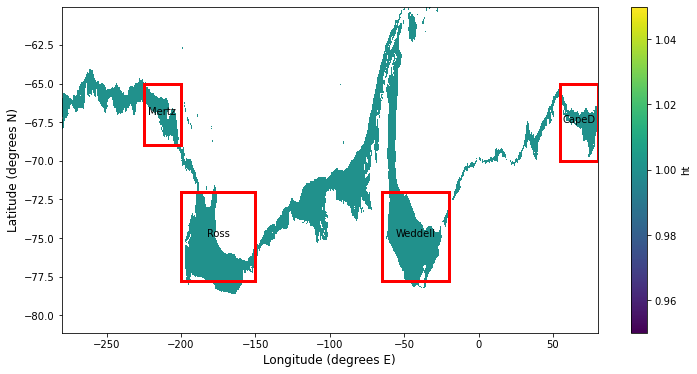

In [27]:
fig=plt.figure(2,(12,6))
ax = plt.subplot()
shelf_mask_wthp.plot()
plt.xlabel('Longitude (degrees E)', fontsize=12)
plt.ylabel('Latitude (degrees N)', fontsize=12)

#Weddell Sea coastal polynyas shelf region
bottomleft_lon=-65
bottomleft_lat=-77.75
topright_lon=-20
topright_lat=-72

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
plt.text((bottomleft_lon+topright_lon)/2, (bottomleft_lat+topright_lat)/2, 'Weddell', horizontalalignment='center')

temp_shelf_wthp_Weddell = temp_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
temp_st_shelf_wthp_Weddell_weighted = temp_shelf_wthp_Weddell.weighted(weights_st_wthp).mean('st_ocean')
temp_st_shelf_wthp_Weddell = temp_st_shelf_wthp_Weddell_weighted.weighted(weights_area_wthp)
temp_surface_shelf_wthp_Weddell = temp_shelf_wthp_Weddell.sel(st_ocean=0, method='nearest').weighted(weights_area_wthp)
temp_250m_shelf_wthp_Weddell = temp_shelf_wthp_Weddell.sel(st_ocean=250, method='nearest').weighted(weights_area_wthp)

salt_shelf_wthp_Weddell = salt_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
salt_st_shelf_wthp_Weddell_weighted = salt_shelf_wthp_Weddell.weighted(weights_st_wthp).mean('st_ocean')
salt_st_shelf_wthp_Weddell = salt_st_shelf_wthp_Weddell_weighted.weighted(weights_area_wthp)
salt_surface_shelf_wthp_Weddell = salt_shelf_wthp_Weddell.sel(st_ocean=0, method='nearest').weighted(weights_area_wthp)
salt_250m_shelf_wthp_Weddell = salt_shelf_wthp_Weddell.sel(st_ocean=250, method='nearest').weighted(weights_area_wthp)

#Ross Sea coastal polynya shelf region
bottomleft_lon=-200
bottomleft_lat=-77.75
topright_lon=-150
topright_lat=-72

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
plt.text((bottomleft_lon+topright_lon)/2, (bottomleft_lat+topright_lat)/2, 'Ross', horizontalalignment='center')

temp_shelf_wthp_Ross = temp_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
temp_st_shelf_wthp_Ross_weighted = temp_shelf_wthp_Ross.weighted(weights_st_wthp).mean('st_ocean')
temp_st_shelf_wthp_Ross = temp_st_shelf_wthp_Ross_weighted.weighted(weights_area_wthp)
temp_surface_shelf_wthp_Ross = temp_shelf_wthp_Ross.sel(st_ocean=0, method='nearest').weighted(weights_area_wthp)
temp_250m_shelf_wthp_Ross = temp_shelf_wthp_Ross.sel(st_ocean=250, method='nearest').weighted(weights_area_wthp)

salt_shelf_wthp_Ross = salt_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
salt_st_shelf_wthp_Ross_weighted = salt_shelf_wthp_Ross.weighted(weights_st_wthp).mean('st_ocean')
salt_st_shelf_wthp_Ross = salt_st_shelf_wthp_Ross_weighted.weighted(weights_area_wthp)
salt_surface_shelf_wthp_Ross = salt_shelf_wthp_Ross.sel(st_ocean=0, method='nearest').weighted(weights_area_wthp)
salt_250m_shelf_wthp_Ross = salt_shelf_wthp_Ross.sel(st_ocean=250, method='nearest').weighted(weights_area_wthp)


#Cape Darnley polynya shelf region
bottomleft_lon=55
bottomleft_lat=-70
topright_lon=80
topright_lat=-65

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
plt.text((bottomleft_lon+topright_lon)/2, (bottomleft_lat+topright_lat)/2, 'CapeD', horizontalalignment='center')

temp_shelf_wthp_CapeD = temp_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
temp_st_shelf_wthp_CapeD_weighted = temp_shelf_wthp_CapeD.weighted(weights_st_wthp).mean('st_ocean')
temp_st_shelf_wthp_CapeD = temp_st_shelf_wthp_CapeD_weighted.weighted(weights_area_wthp)
temp_surface_shelf_wthp_CapeD = temp_shelf_wthp_CapeD.sel(st_ocean=0, method='nearest').weighted(weights_area_wthp)
temp_250m_shelf_wthp_CapeD = temp_shelf_wthp_CapeD.sel(st_ocean=250, method='nearest').weighted(weights_area_wthp)

salt_shelf_wthp_CapeD = salt_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
salt_st_shelf_wthp_CapeD_weighted = salt_shelf_wthp_CapeD.weighted(weights_st_wthp).mean('st_ocean')
salt_st_shelf_wthp_CapeD = salt_st_shelf_wthp_CapeD_weighted.weighted(weights_area_wthp)
salt_surface_shelf_wthp_CapeD = salt_shelf_wthp_CapeD.sel(st_ocean=0, method='nearest').weighted(weights_area_wthp)
salt_250m_shelf_wthp_CapeD = salt_shelf_wthp_CapeD.sel(st_ocean=250, method='nearest').weighted(weights_area_wthp)


#Mertz Glacier Polynya shelf region
bottomleft_lon=-225
bottomleft_lat=-69
topright_lon=-200
topright_lat=-65

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
plt.text((bottomleft_lon+topright_lon)/2, (bottomleft_lat+topright_lat)/2, 'Mertz', horizontalalignment='center')

temp_shelf_wthp_Mertz = temp_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
temp_st_shelf_wthp_Mertz_weighted = temp_shelf_wthp_Mertz.weighted(weights_st_wthp).mean('st_ocean')
temp_st_shelf_wthp_Mertz = temp_st_shelf_wthp_Mertz_weighted.weighted(weights_area_wthp)
temp_surface_shelf_wthp_Mertz = temp_shelf_wthp_Mertz.sel(st_ocean=0, method='nearest').weighted(weights_area_wthp)
temp_250m_shelf_wthp_Mertz = temp_shelf_wthp_Mertz.sel(st_ocean=250, method='nearest').weighted(weights_area_wthp)

salt_shelf_wthp_Mertz = salt_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
salt_st_shelf_wthp_Mertz_weighted = salt_shelf_wthp_Mertz.weighted(weights_st_wthp).mean('st_ocean')
salt_st_shelf_wthp_Mertz = salt_st_shelf_wthp_Mertz_weighted.weighted(weights_area_wthp)
salt_surface_shelf_wthp_Mertz = salt_shelf_wthp_Mertz.sel(st_ocean=0, method='nearest').weighted(weights_area_wthp)
salt_250m_shelf_wthp_Mertz = salt_shelf_wthp_Mertz.sel(st_ocean=250, method='nearest').weighted(weights_area_wthp)

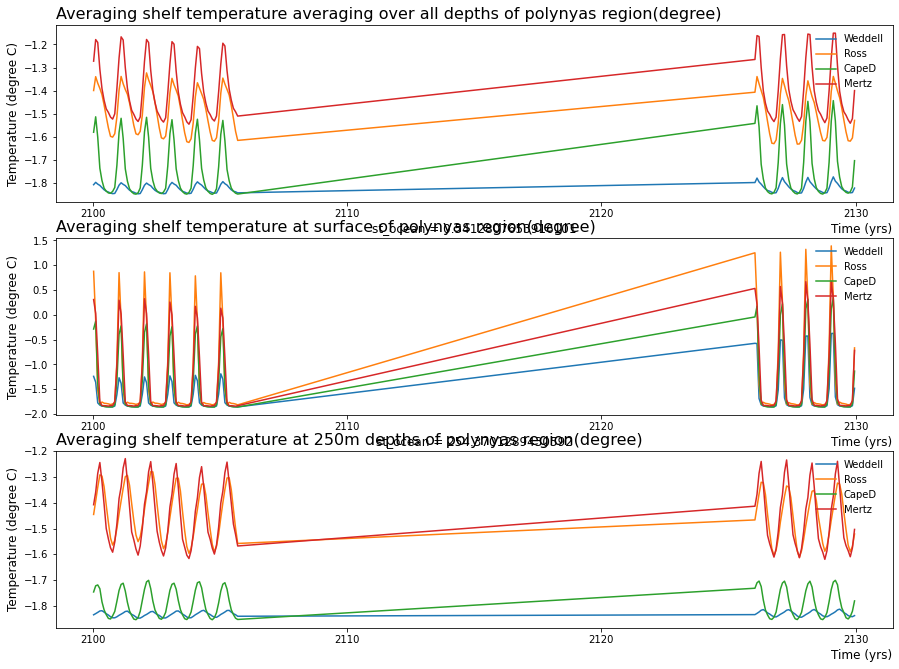

In [28]:
fig = plt.figure(figsize=(15, 15))

#Plotting mean shelf temperature at surface, 250m and averaging over all depths
plt.subplot(4,1,1)
plt.title('Averaging shelf temperature averaging over all depths of polynyas region(degree)', fontsize=16, loc='left')
temp_st_shelf_wthp_Weddell.mean(("xt_ocean", "yt_ocean")).plot(label='Weddell')
temp_st_shelf_wthp_Ross.mean(("xt_ocean", "yt_ocean")).plot(label='Ross')
temp_st_shelf_wthp_CapeD.mean(("xt_ocean", "yt_ocean")).plot(label='CapeD')
temp_st_shelf_wthp_Mertz.mean(("xt_ocean", "yt_ocean")).plot(label='Mertz')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=4)

plt.subplot(4,1,2)
plt.title('Averaging shelf temperature at surface of polynyas region(degree)', fontsize=16, loc='left')
temp_surface_shelf_wthp_Weddell.mean(("xt_ocean", "yt_ocean")).plot(label='Weddell')
temp_surface_shelf_wthp_Ross.mean(("xt_ocean", "yt_ocean")).plot(label='Ross')
temp_surface_shelf_wthp_CapeD.mean(("xt_ocean", "yt_ocean")).plot(label='CapeD')
temp_surface_shelf_wthp_Mertz.mean(("xt_ocean", "yt_ocean")).plot(label='Mertz')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=4)

plt.subplot(4,1,3)
plt.title('Averaging shelf temperature at 250m depths of polynyas region(degree)', fontsize=16, loc='left')
temp_250m_shelf_wthp_Weddell.mean(("xt_ocean","yt_ocean")).plot(label='Weddell')
temp_250m_shelf_wthp_Ross.mean(("xt_ocean","yt_ocean")).plot(label='Ross')
temp_250m_shelf_wthp_CapeD.mean(("xt_ocean","yt_ocean")).plot(label='CapeD')
temp_250m_shelf_wthp_Mertz.mean(("xt_ocean","yt_ocean")).plot(label='Mertz')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=4)

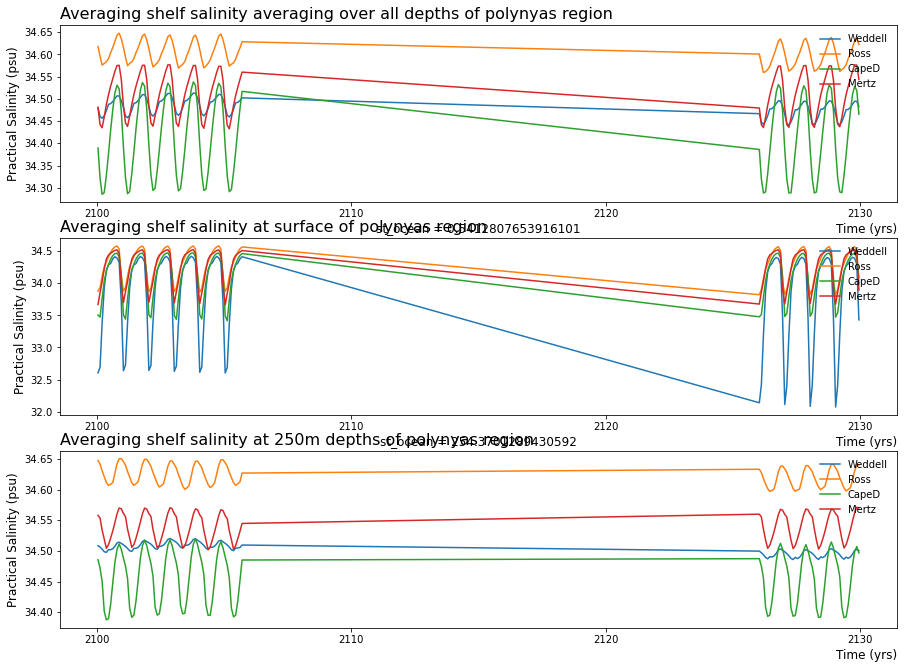

In [22]:
fig = plt.figure(figsize=(15, 15))

#Plotting mean shelf salinity at surface, 250m and averaging over all depths
plt.subplot(4,1,1)
plt.title('Averaging shelf salinity averaging over all depths of polynyas region', fontsize=16, loc='left')
salt_st_shelf_wthp_Weddell.mean(("xt_ocean", "yt_ocean")).plot(label='Weddell')
salt_st_shelf_wthp_Ross.mean(("xt_ocean", "yt_ocean")).plot(label='Ross')
salt_st_shelf_wthp_CapeD.mean(("xt_ocean", "yt_ocean")).plot(label='CapeD')
salt_st_shelf_wthp_Mertz.mean(("xt_ocean", "yt_ocean")).plot(label='Mertz')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=4)

plt.subplot(4,1,2)
plt.title('Averaging shelf salinity at surface of polynyas region', fontsize=16, loc='left')
salt_surface_shelf_wthp_Weddell.mean(("xt_ocean", "yt_ocean")).plot(label='Weddell')
salt_surface_shelf_wthp_Ross.mean(("xt_ocean", "yt_ocean")).plot(label='Ross')
salt_surface_shelf_wthp_CapeD.mean(("xt_ocean", "yt_ocean")).plot(label='CapeD')
salt_surface_shelf_wthp_Mertz.mean(("xt_ocean", "yt_ocean")).plot(label='Mertz')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=4)

plt.subplot(4,1,3)
plt.title('Averaging shelf salinity at 250m depths of polynyas region', fontsize=16, loc='left')
salt_250m_shelf_wthp_Weddell.mean(("xt_ocean","yt_ocean")).plot(label='Weddell')
salt_250m_shelf_wthp_Ross.mean(("xt_ocean","yt_ocean")).plot(label='Ross')
salt_250m_shelf_wthp_CapeD.mean(("xt_ocean","yt_ocean")).plot(label='CapeD')
salt_250m_shelf_wthp_Mertz.mean(("xt_ocean","yt_ocean")).plot(label='Mertz')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=4)

## Experiment:	01deg_jra55v13_ryf9091_qian_wthmp
Now, make a `land_mask`. This is just a dataarray with `1`'s where you have ocean and `0`'s where you have land. We are going to work with this mask to delineate the different ocean basins.

In [23]:
land_mask_wthmp = ~ht_wthmp.isnull()
shelf_mask_wthmp = (land_mask_wthmp.where(ht_wthmp < 1000))

In [ ]:
fig=plt.figure(2,(12,6))
ax = plt.subplot()
shelf_mask_wthmp.plot()
plt.xlabel('Longitude (degrees E)', fontsize=12)
plt.ylabel('Latitude (degrees N)', fontsize=12)


#Weddell Sea coastal polynyas shelf region
bottomleft_lon=-65
bottomleft_lat=-77.75
topright_lon=-20
topright_lat=-72

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
plt.text((bottomleft_lon+topright_lon)/2, (bottomleft_lat+topright_lat)/2, 'Weddell', horizontalalignment='center')

salt_shelf_wthmp_Weddell = salt_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
salt_st_shelf_wthmp_Weddell_weighted = salt_shelf_wthmp_Weddell.weighted(weights_st_wthmp).mean('st_ocean')
salt_st_shelf_wthmp_Weddell = salt_st_shelf_wthmp_Weddell_weighted.weighted(weights_area_wthmp)
salt_surface_shelf_wthmp_Weddell = salt_shelf_wthmp_Weddell.sel(st_ocean=0, method='nearest').weighted(weights_area_wthmp)
salt_250m_shelf_wthmp_Weddell = salt_shelf_wthmp_Weddell.sel(st_ocean=250, method='nearest').weighted(weights_area_wthmp)


#Ross Sea coastal polynya shelf region
bottomleft_lon=-200
bottomleft_lat=-77.75
topright_lon=-150
topright_lat=-72

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
plt.text((bottomleft_lon+topright_lon)/2, (bottomleft_lat+topright_lat)/2, 'Ross', horizontalalignment='center')

salt_shelf_wthmp_Ross = salt_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
salt_st_shelf_wthmp_Ross_weighted = salt_shelf_wthmp_Ross.weighted(weights_st_wthmp).mean('st_ocean')
salt_st_shelf_wthmp_Ross = salt_st_shelf_wthmp_Ross_weighted.weighted(weights_area_wthmp)
salt_surface_shelf_wthmp_Ross = salt_shelf_wthmp_Ross.sel(st_ocean=0, method='nearest').weighted(weights_area_wthmp)
salt_250m_shelf_wthmp_Ross = salt_shelf_wthmp_Ross.sel(st_ocean=250, method='nearest').weighted(weights_area_wthmp)


#Cape Darnley polynya shelf region
bottomleft_lon=55
bottomleft_lat=-70
topright_lon=80
topright_lat=-65

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)

salt_shelf_wthmp_CapeD = salt_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
salt_st_shelf_wthmp_CapeD_weighted = salt_shelf_wthmp_CapeD.weighted(weights_st_wthmp).mean('st_ocean')
salt_st_shelf_wthmp_CapeD = salt_st_shelf_wthmp_CapeD_weighted.weighted(weights_area_wthmp)
salt_surface_shelf_wthmp_CapeD = salt_shelf_wthmp_CapeD.sel(st_ocean=0, method='nearest').weighted(weights_area_wthmp)
salt_250m_shelf_wthmp_CapeD = salt_shelf_wthmp_CapeD.sel(st_ocean=250, method='nearest').weighted(weights_area_wthmp)
plt.text((bottomleft_lon+topright_lon)/2, (bottomleft_lat+topright_lat)/2, 'CapeD', horizontalalignment='center')

#Mertz Glacier Polynya shelf region
bottomleft_lon=-225
bottomleft_lat=-69
topright_lon=-200
topright_lat=-65

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
plt.text((bottomleft_lon+topright_lon)/2, (bottomleft_lat+topright_lat)/2, 'Mertz', horizontalalignment='center')

salt_shelf_wthmp_Mertz = salt_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
salt_st_shelf_wthmp_Mertz_weighted = salt_shelf_wthmp_Mertz.weighted(weights_st_wthmp).mean('st_ocean')
salt_st_shelf_wthmp_Mertz = salt_st_shelf_wthmp_Mertz_weighted.weighted(weights_area_wthmp)
salt_surface_shelf_wthmp_Mertz = salt_shelf_wthmp_Mertz.sel(st_ocean=0, method='nearest').weighted(weights_area_wthmp)
salt_250m_shelf_wthmp_Mertz = salt_shelf_wthmp_Mertz.sel(st_ocean=250, method='nearest').weighted(weights_area_wthmp)

NameError: name 'salt_st_shelf_wthmp_Mertz' is not defined

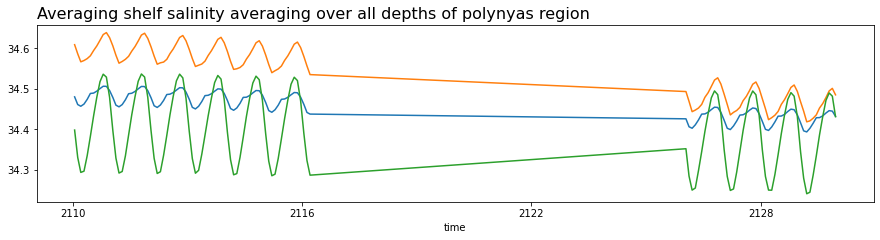

In [25]:
fig = plt.figure(figsize=(15, 15))

#Plotting mean shelf salinity at surface, 250m and averaging over all depths
plt.subplot(4,1,1)
plt.title('Averaging shelf salinity averaging over all depths of polynyas region', fontsize=16, loc='left')
salt_st_shelf_wthmp_Weddell.mean(("xt_ocean", "yt_ocean")).plot(label='Weddell')
salt_st_shelf_wthmp_Ross.mean(("xt_ocean", "yt_ocean")).plot(label='Ross')
salt_st_shelf_wthmp_CapeD.mean(("xt_ocean", "yt_ocean")).plot(label='CapeD')
salt_st_shelf_wthmp_Mertz.mean(("xt_ocean", "yt_ocean")).plot(label='Mertz')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=4)

plt.subplot(4,1,2)
plt.title('Averaging shelf salinity at surface of polynyas region', fontsize=16, loc='left')
salt_surface_shelf_wthmp_Weddell.mean(("xt_ocean", "yt_ocean")).plot(label='Weddell')
salt_surface_shelf_wthmp_Ross.mean(("xt_ocean", "yt_ocean")).plot(label='Ross')
salt_surface_shelf_wthmp_CapeD.mean(("xt_ocean", "yt_ocean")).plot(label='CapeD')
salt_surface_shelf_wthmp_Mertz.mean(("xt_ocean", "yt_ocean")).plot(label='Mertz')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=4)

plt.subplot(4,1,3)
plt.title('Averaging shelf salinity at 250m depths of polynyas region', fontsize=16, loc='left')
salt_250m_shelf_wthmp_Weddell.mean(("xt_ocean","yt_ocean")).plot(label='Weddell')
salt_250m_shelf_wthmp_Ross.mean(("xt_ocean","yt_ocean")).plot(label='Ross')
salt_250m_shelf_wthmp_CapeD.mean(("xt_ocean","yt_ocean")).plot(label='CapeD')
salt_250m_shelf_wthmp_Mertz.mean(("xt_ocean","yt_ocean")).plot(label='Mertz')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=4)